<h1 align = 'center'> Neural Networks Demystified </h1>
<h2 align = 'center'> Part 3: Gradient Descent </h2>


<h4 align = 'center' > @stephencwelch </h4>

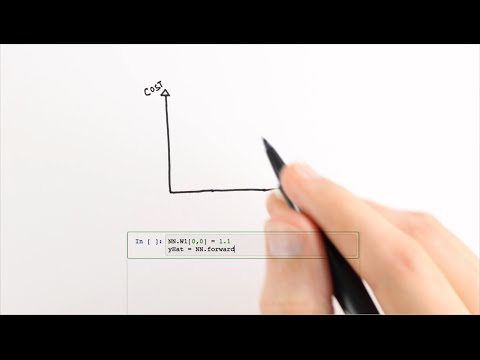

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('5u0jaA3qAGk')

<h3 align = 'center'> Variables </h3>

|Code Symbol | Math Symbol | Definition | Dimensions
| :-: | :-: | :-: | :-: |
|X|$$X$$|Input Data, each row in an example| (numExamples, inputLayerSize)|
|y |$$y$$|target data|(numExamples, outputLayerSize)|
|W1 | $$W^{(1)}$$ | Layer 1 weights | (inputLayerSize, hiddenLayerSize) |
|W2 | $$W^{(2)}$$ | Layer 2 weights | (hiddenLayerSize, outputLayerSize) |
|z2 | $$z^{(2)}$$ | Layer 2 activation | (numExamples, hiddenLayerSize) |
|a2 | $$a^{(2)}$$ | Layer 2 activity | (numExamples, hiddenLayerSize) |
|z3 | $$z^{(3)}$$ | Layer 3 activation | (numExamples, outputLayerSize) |
|J | $$J$$ | Cost | (1, outputLayerSize) |

Last time we built a neural network in python that made really bad predictions of your score on a test based on how many hours you slept and how many hours you studied the night before. This time we'll focus on the theory of making those predictions better.

We can initialize the network we built last time and pass in our normalized data, X, using our forward method, and have a look at our estimate of y, yHat.

In [2]:
%pylab inline

#Import code from last time:
from partTwo import *

Populating the interactive namespace from numpy and matplotlib


In [3]:
NN = Neural_Network()

In [4]:
yHat = NN.forward(X)

In [5]:
yHat

array([[0.32522079],
       [0.33674479],
       [0.31012999]])

In [17]:
y

array([[0.75],
       [0.82],
       [0.93]])

TypeError: only size-1 arrays can be converted to Python scalars

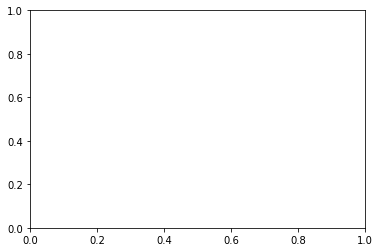

In [20]:
#Compare estimate, yHat, to actually score
bar2 = np.vectorize(bar)
bar([0,1,2], y, width = 0.35, alpha=0.8)
bar([0.35,1.35,2.35],yHat, width = 0.35, color='r', alpha=0.8)
grid(1)
legend(['y', 'yHat'])

Right now our predictions are pretty inaccurate. To improve our model, we first need to quantify exactly how wrong our predictions are. We'll do this with a cost function. A cost function allows us to express exactly how wrong or "costly" our models is, given our examples.

One way to compute an overall cost is to take each error value, square it, and add these values together. Multiplying by one half will make things simpler down the road. Now that we have a cost, or job is to minimize it. When someone says they’re training a network, what they really mean is that they're minimizing a cost function. 

$$
J = \sum \frac{1}{2}(y-\hat{y})^2 \tag{5}
$$

OUR cost is a function of two things, our examples, and the weights on our synapses. We don't have much control of our data, so we'll minimize our cost by changing the weights.

Conceptually, this is pretty simple concept. We have a collection of 9 individual weights, and we're saying that there is some combination of w's that will make our cost, J, as small as possible. When I first saw this problem in machine learning, I thought, I'll just try ALL THE WEIGHTS UNTIL I FIND THE BEST ONE! After all I have a computer!

Enter the CURSE OF DIMENSIONALITY. Here's the problem. Let's pretend for a second that we only have 1 weight, instead of 9. To find the ideal value of our weight that will minimize our cost, we need to try a bunch of values for W, let's say we test 1000 values. That doesn't seem so bad, after all, my computer is pretty fast.

In [ ]:
import time

weightsToTry = np.linspace(-5,5,1000)
costs = np.zeros(1000)

startTime = time.clock()
for i in range(1000):
    NN.W1[0,0] = weightsToTry[i]
    yHat = NN.forward(X)
    costs[i] = 0.5*sum((y-yHat)**2)
    
endTime = time.clock()

In [ ]:
timeElapsed = endTime-startTime
timeElapsed

It takes about 0.04 seconds to check 1000 different weight values for our neural network. Since we’ve computed the cost for a wide range values of W, we can just pick the one with the smallest cost, let that be our weight, and we’ve trained our network.

In [ ]:
plot(weightsToTry, costs)
grid(1)
ylabel('Cost')
xlabel('Weight')

So you may be thinking that 0.04 seconds to train a network is not so bad, and we haven't even optimized anything yet. Plus, there are other, way faster languages than python our there. 

Before we optimize through, let's consider the full complexity of the problem. Remember the 0.04 seconds required is only for one weight, and we have 9 total! Let's next consider 2 weights for a moment. To maintain the same precision we now need to check 1000 times 1000, or one million values. This is a lot of work, even for a fast computer.

In [ ]:
weightsToTry = np.linspace(-5,5,1000)
costs = np.zeros((1000, 1000))

startTime = time.clock()
for i in range(1000):
    for j in range(1000):
        NN.W1[0,0] = weightsToTry[i]
        NN.W1[0,1] = weightsToTry[j]
        yHat = NN.forward(X)
        costs[i, j] = 0.5*sum((y-yHat)**2)
    
endTime = time.clock()

In [ ]:
timeElapsed = endTime-startTime
timeElapsed

After our 1 million evaluations we’ve found our solution, but it took an agonizing 40 seconds! The real curse of dimensionality kicks in as we continue to add dimensions. Searching through three weights would take a billion evaluations, or 11 hours! Searching through all 9 weights we need for our simple network would take 1,268,391,679,350,583.5 years. (Over a quardrillion years). So for that reason, the "just try everything" or brute force optimization method is clearly not going to work.

In [ ]:
0.04*(1000**(9-1))/(3600*24*365)

Let's return to the 1-dimensional case and see if we can be more clever. Let's evaluate our cost function for a specific value of w. If w is 1.1 for example, we can run our cost function, and see that J is 2.8. Now we haven't learned much yet, but let's try to add a little information to what we already know. What if we could figure out which way was downhill? If we could, we would know whether to make W smaller or larger do decrease the cost. We could test the cost function immediately to the left and right of our test point and see which is smaller. This is called numerical estimation, and is sometimes a good approach, but for us, there's a faster way. Let's look at our equations so far.

$$
z^{(2)} = XW^{(1)} \tag{1}\\
$$
$$
a^{(2)} = f(z^{(2)}) \tag{2}\\
$$
$$
z^{(3)} = a^{(2)}W^{(2)} \tag{3}\\
$$
$$
\hat{y} = f(z^{(3)}) \tag{4}\\
$$
$$
J = \sum \frac{1}{2}(y-\hat{y})^2 \tag{5}\\
$$

We have 5 equations, but we can really think of them as one big equation.


And since we have one big equation that uniquely determines our cost, J, from X, y, W1, and W2, we can use our good friend calculus to find what we're looking for. We want to know "which way is downhill", that is, what is the rate of change of J with respect to W, also known as the derivative. And in this case, since we’re just considering one weight at a time, the partial derivative. 

We can derive an expression for dJdW, that will give us the rate of change of J with respect to W, for any value of W! If dJdW is positive, then the cost function is going uphill. If dJdW is negative the cost function is going downhill. 

Now we can really speed things up. Since we know in which direction the cost decreases, we can save all that time we would have spent searching in the wrong direction. We can save even more computational time by iteratively taking steps downhill and stopping when the cost stops getting smaller. 

This method is known as gradient descent, and although it may not seem so impressive in one dimension, it is capable of incredible speedups in higher dimensions. In fact, in our final video, we’ll show that what would have taken 10^27 function evaluations with our brute force method will take less than 100 evaluations with gradient descent. Gradient descent allows us to find needles in very very very large haystacks. 

Now before we celebrate too much here, there is a restriction. What if our cost function doesn't always go in the same direction? What if it goes up, then back down? The mathematical name for this is non-convex, and it could really throw off our gradient descent algorithm by getting it stuck in a local minima instead of our ideal global minima. One of the reasons we chose our cost function to be the sum of squared errors was to exploit the convex nature of quadratic equations.

We know that the graph of y equals x squared is a nice convex parabola and it turns out that higher dimensional versions are too!

Another piece of the puzzle here is that depending on how we use our data, it might not matter if or cost function is convex or not. If we use our examples one at a time instead of all at once, sometimes it won't matter if our cost function is convex, we will still find a good solution. This is called stochastic gradient descent. So maybe we shouldn't be afraid of non-convex cost functions, as Neural Network wizard Yann Lecun says in his excellent talk "Who is afraid on non-convex loss funtions?"

Link to Yann's Talk:
http://videolectures.net/eml07_lecun_wia/

The details of gradient descent are a deep topic for another day, for now we're going to do our gradient descent "batch" style, where we use all our example at once, and the way we've setup our cost function will keep things nice and convex. Next time we'll compute and code up our gradients!